In [2]:
# Import Necessary Libraries
import os
import numpy as np
from datetime import datetime
import pysteps
import utility   
import matplotlib.pyplot as plt
from pprint import pprint
from pysteps import nowcasts, motion
from pysteps.motion.lucaskanade import dense_lucaskanade
from pysteps.visualization import plot_precip_field
import warnings
warnings.filterwarnings('ignore')

Pysteps configuration file found at: C:\Users\Utente\anaconda3\envs\radar_nowcasting_env\lib\site-packages\pysteps\pystepsrc



In [3]:
root_path = os.getcwd()
# Define the data directory for the repository data
data_path = os.path.join(root_path, "Data")
# Define metadata files
metadata_X = utility.get_matadata(os.path.join(data_path, "radarmappatipo.tif"), type="X")
folders = [folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]
events = [event for event in os.listdir(os.path.join(data_path,
                                                     'UNICA_SG')) if os.path.isdir(os.path.join(data_path,
                                                                                                'UNICA_SG', event))]
# Define parameters for X-band radar data
data_source_X = 'UNICA_SG'
event_subdir ='20230520_2235' # this is the event folder, we can change for different events from the events variable
f_ext_X = "png"
# for LK, VET and proesman we need 4 files (3 previous files from the central scan) and for DARTS we need 10 files (9 previous files)
num_prev_files = 2  
num_next_files = 6 # In our study we are doing nowcast for next 30 mins (6 scans) 
timestep = 5
# Choose the date for particular subset
eventdates = [eventdate for eventdate in os.listdir(os.path.join(data_path,
                                                                 'UNICA_SG',
                                                                 event_subdir)) if os.path.isfile(os.path.join(data_path,
                                                                                                               'UNICA_SG', 
                                                                                                               event_subdir,
                                                                                                               eventdate))]
# extract the date in datetime format from the filename
# This is the central scan, we have to previous load files for optical flow and next files to compare the nowacasting results with observation
date = datetime.strptime('20230520_1830.png', "%Y%m%d_%H%M.png") 
# Load X-band radar data
R_dn, metadata_dn = utility.import_files_by_date(date, 
                                           data_path, 
                                           data_source_X,
                                           event_subdir, 
                                           f_ext_X, 
                                           metadata_X,
                                           num_prev_files,
                                           0,
                                           timestep)


# Noise removal using Watershed technique
R_dn_clean = np.empty_like(R_dn)
for t in range(R_dn.shape[0]):
    R_dn_clean[t, :, :] = utility.noise_remove(R_dn[t, :, :], type="Watershed")

metadata_dn['zr_a']= 200
metadata_dn['zr_b']= 1.6
# Convert Digital Number to Reflectivity (dBZ)
R_dbz,metadata_dbz = utility.dn_to_dbz(R_dn_clean,metadata_dn)
# transform the reflectivity
R_dbz = R_dbz*1.5


# Set missing values with the fill value
R_dbz[~np.isfinite(R_dbz)] = 0

In [4]:
R_O, metadata_O = utility.import_files_by_date(date, 
                                               data_path, 
                                               data_source_X,
                                               event_subdir, 
                                               f_ext_X, 
                                               metadata_X,
                                               None,
                                               num_next_files,
                                               timestep)

metadata_O['zr_a']= 200
metadata_O['zr_b']= 1.6
# Noise removal using Watershed technique
R_O_clean = np.empty_like(R_O)
for t in range(R_O.shape[0]):
    R_O_clean[t, :, :] = utility.noise_remove(R_O[t, :, :], type="Watershed")

# Convert Digital Number to Reflectivity (dBZ)
R_O_dbz,metadata_O_dbz = utility.dn_to_dbz(R_O_clean,metadata_O)
# transformed the reflectivity
R_O_dbz = R_O_dbz*1.5

In [5]:
# motion field using lucas kanade optical flow (dense method) with shitomasi tracking methods
from pysteps.visualization import quiver

Computing the motion field with the Lucas-Kanade method.
--- 7 outliers detected ---
--- LK found 196 sparse vectors ---
--- 93 samples left after declustering ---
--- total time: 3.41 seconds ---


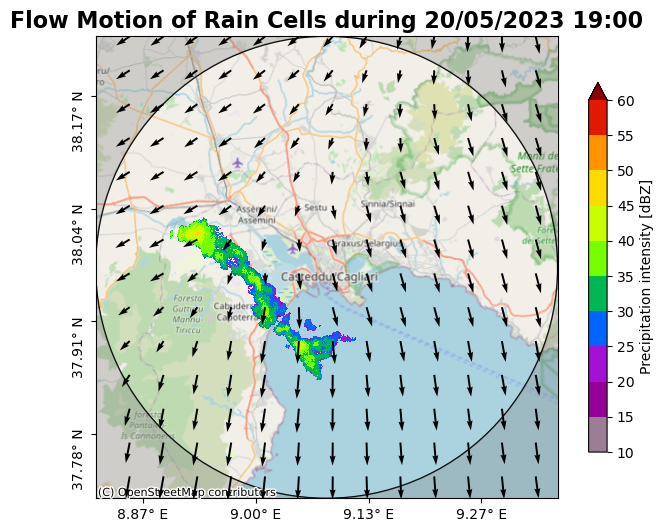

In [9]:
# V = dense_lucaskanade(R_dbz,fd_method="shitomasi",verbose=True)
oflow_method = motion.get_method("LK")
V = oflow_method(R_dbz,verbose=True)
fig, ax = plt.subplots(figsize=(8,6))
plot_precip_field(
            R_dbz[-1, :, :],
            ptype="intensity",
            geodata=metadata_dbz,
            units="dBZ",
            ax=ax,
            colorscale="pysteps")
ax.set_title(f"Flow Motion of Rain Cells during {metadata_dbz['timestamps'][-1].strftime('%d/%m/%Y %H:%M')}", fontsize=16,weight="bold")
quiver(V, geodata=metadata_dbz, step=75,ax=ax)     
utility.plot_modification(ax,metadata_dbz)
plt.savefig("dense_lk_motion.png", dpi=300, bbox_inches="tight")
plt.show()

# Nowcast with STEPS

In [11]:
# Set nowcast parameters
n_ens_members = 6
n_cascade_levels = 6
n_leadtimes = num_next_files
seed = 24
timestep = 5.0
# The S-PROG nowcast
steps = nowcasts.get_method("steps")
R_f_steps = steps(
    R_dbz[-3:, :, :],
    V,
    n_leadtimes,
    n_ens_members,
    n_cascade_levels,
    R_thr=0,
    kmperpixel=60.0/1000.0,
    timestep=timestep,
    noise_method="nonparametric",
    vel_pert_method="bps",
    mask_method="incremental",
    seed=seed,
    num_workers=6
)

Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 1024x1024
km/pixel:         0.06
time step:        5.0 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     6
ensemble size:            6
parallel threads:         6
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: 0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------

In [12]:
# Time indices corresponding to t-15 min, t-10 min, t-5 min, t min
input_indices = [0,1,2]
# Time indices corresponding to t+5 min, t+10 min, t+15 min and t+30 min
output_indices = [0,1,2,5]
# Subplot radar data with improved aesthetics
def plot_radar_data(data, metadata, time_indices, text):
    fig, axes = plt.subplots(1, len(time_indices), figsize=(32, 8))
    for i, idx in enumerate(time_indices):
        ax = axes[i]
        plot_precip_field(
            data[idx, :, :],
            ptype="intensity",
            geodata=metadata,
            units="dBZ",
            ax=ax,
            colorscale="pysteps"
        )
        ax.set_title(f"{text} {metadata['timestamps'][idx].strftime('%d/%m/%Y %H:%M')}", fontsize=12,weight="bold")
        utility.plot_modification(ax, metadata)
    plt.tight_layout()
    # plt.savefig(f"{text.lower().strip()}_radar_data.png", dpi=300, bbox_inches="tight")
    plt.show()

In [13]:
# plot_radar_data(R_dbz, metadata_dbz, input_indices, "Input ")

In [14]:
# plot_radar_data(R_O_dbz, metadata_O_dbz, output_indices, "Output ")

In [15]:
# plot_radar_data(R_f_steps[0], metadata_O_dbz, output_indices, "STEPS Nowcast-member-0")

In [16]:
# plot_radar_data(R_f_steps[1], metadata_O_dbz, output_indices, "STEPS Nowcast-member-1")

In [17]:
# plot_radar_data(R_f_steps[2], metadata_O_dbz, output_indices, "STEPS Nowcast-member-2")

In [18]:
# plot_radar_data(R_f_steps[3], metadata_O_dbz, output_indices, "STEPS Nowcast-member-3")

In [19]:
# plot_radar_data(R_f_steps[4], metadata_O_dbz, output_indices, "STEPS Nowcast-member-4")

In [20]:
# plot_radar_data(R_f_steps[5], metadata_O_dbz, output_indices, "STEPS Nowcast-member-5")

In [21]:
R_f_steps_mean = np.nanmean(R_f_steps,axis=0)

In [22]:
# plot_radar_data(R_f_steps_mean, metadata_O_dbz, output_indices, "STEPS Nowcast-mean")

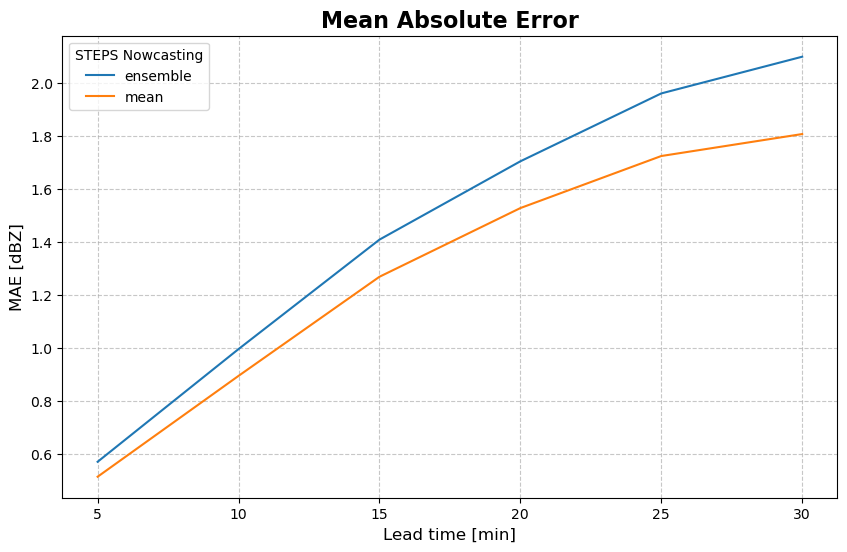

In [23]:
from pysteps import verification
# Compute MAE for all lead times
x = np.arange(1, n_leadtimes + 1) * timestep
mae =  verification.get_method("MAE",type="deterministic")
mae_ens = verification.get_method("ens_skill",type="ensemble")
mae_score_ens =[]
mae_score =[]
for i in range(n_leadtimes):
    mae_score.append(mae(R_f_steps_mean[i,:,:], R_O_dbz[i, :, :])['MAE'])
    mae_score_ens.append(mae_ens(R_f_steps[:,i,:,:], R_O_dbz[i, :, :],'MAE'))
plt.figure(figsize=(10, 6))
plt.plot(x, mae_score_ens, label='ensemble')
plt.plot(x, mae_score, label ="mean")
plt.xlabel("Lead time [min]", fontsize=12)
plt.ylabel("MAE [dBZ]", fontsize=12)
plt.title("Mean Absolute Error", fontsize=16, weight="bold")
plt.legend(title="STEPS Nowcasting", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

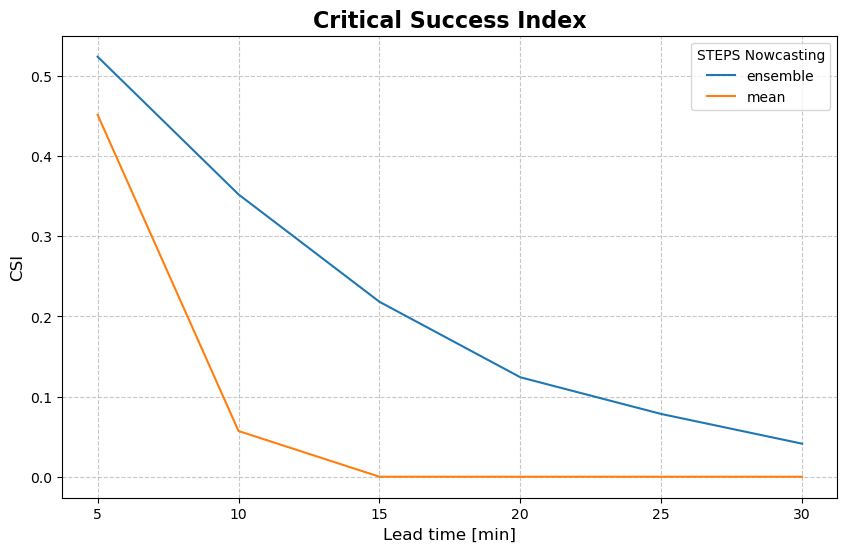

In [24]:
# Compute CSI for all lead times
x = np.arange(1, n_leadtimes + 1) * timestep
csi =  verification.get_method("CSI",type="deterministic")
csi_ens = verification.get_method("ens_skill",type="ensemble")
csi_score_ens =[]
csi_score =[]
for i in range(n_leadtimes):
    csi_score.append(csi(R_f_steps_mean[i,:,:], R_O_dbz[i, :, :],thr = 30)['CSI'])
    csi_score_ens.append(csi_ens(R_f_steps[:,i,:,:], R_O_dbz[i, :, :],'CSI',thr=30))
plt.figure(figsize=(10, 6))
plt.plot(x, csi_score_ens, label='ensemble')
plt.plot(x, csi_score, label ="mean")
plt.xlabel("Lead time [min]", fontsize=12)
plt.ylabel("CSI", fontsize=12)
plt.title("Critical Success Index", fontsize=16, weight="bold")
plt.legend(title="STEPS Nowcasting", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

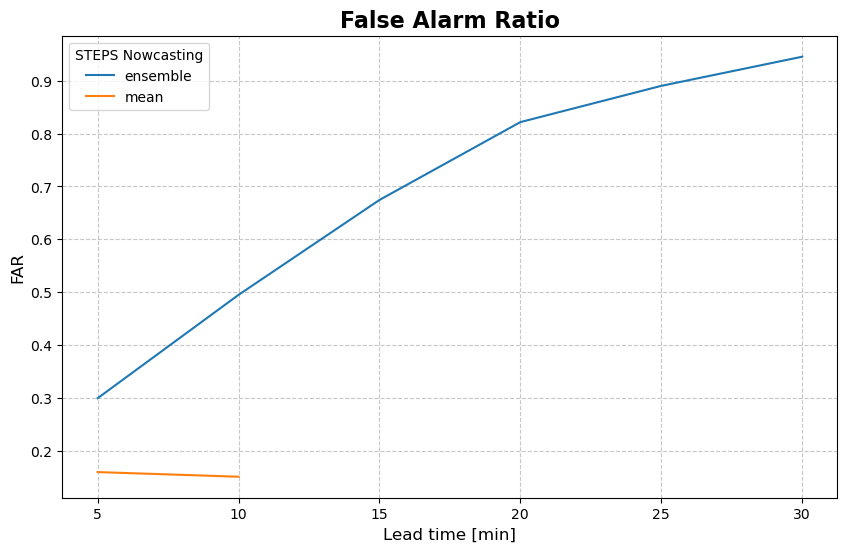

In [25]:
# Compute FAR for all lead times
x = np.arange(1, n_leadtimes + 1) * timestep
far =  verification.get_method("FAR",type="deterministic")
far_ens = verification.get_method("ens_skill",type="ensemble")
far_score_ens =[]
far_score =[]
for i in range(n_leadtimes):
    far_score.append(far(R_f_steps_mean[i,:,:], R_O_dbz[i, :, :],thr = 30)['FAR'])
    far_score_ens.append(far_ens(R_f_steps[:,i,:,:], R_O_dbz[i, :, :],'FAR',thr=30))
plt.figure(figsize=(10, 6))
plt.plot(x, far_score_ens, label='ensemble')
plt.plot(x, far_score, label ="mean")
plt.xlabel("Lead time [min]", fontsize=12)
plt.ylabel("FAR", fontsize=12)
plt.title("False Alarm Ratio", fontsize=16, weight="bold")
plt.legend(title="STEPS Nowcasting", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

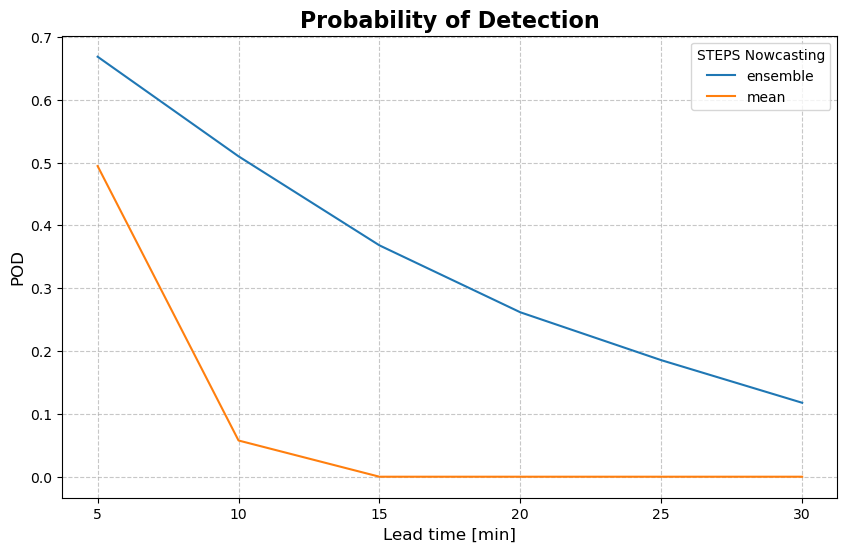

In [26]:
# Compute POD for all lead times
x = np.arange(1, n_leadtimes + 1) * timestep
pod =  verification.get_method("POD",type="deterministic")
pod_ens = verification.get_method("ens_skill",type="ensemble")
pod_score_ens =[]
pod_score =[]
for i in range(n_leadtimes):
    pod_score.append(pod(R_f_steps_mean[i,:,:], R_O_dbz[i, :, :],thr = 30)['POD'])
    pod_score_ens.append(pod_ens(R_f_steps[:,i,:,:], R_O_dbz[i, :, :],'POD',thr=30))
plt.figure(figsize=(10, 6))
plt.plot(x, pod_score_ens, label='ensemble')
plt.plot(x, pod_score, label ="mean")
plt.xlabel("Lead time [min]", fontsize=12)
plt.ylabel("POD", fontsize=12)
plt.title("Probability of Detection", fontsize=16, weight="bold")
plt.legend(title="STEPS Nowcasting", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

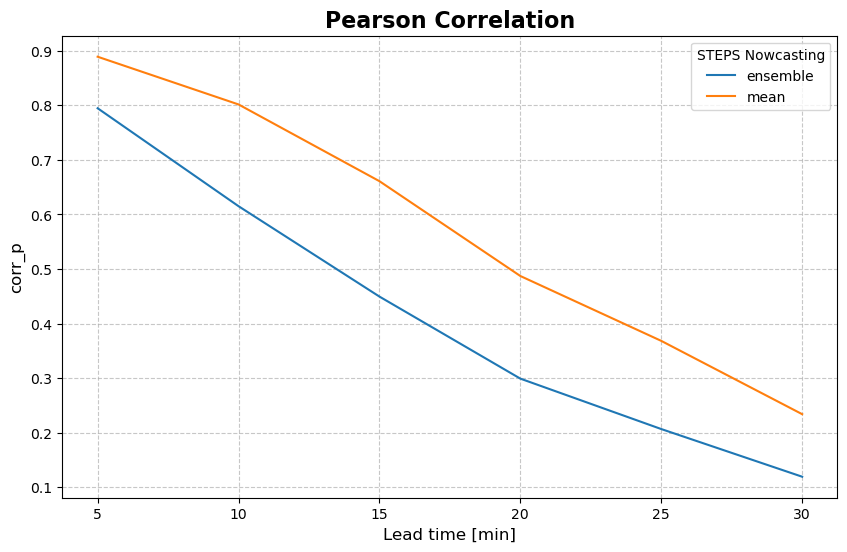

In [27]:
# Compute Pearson Correlation for all lead times
x = np.arange(1, n_leadtimes + 1) * timestep
corr_p =  verification.get_method("corr_p",type="deterministic")
corr_p_ens = verification.get_method("ens_skill",type="ensemble")
corr_p_score_ens =[]
corr_p_score =[]
for i in range(n_leadtimes):
    corr_p_score.append(corr_p(R_f_steps_mean[i,:,:], R_O_dbz[i, :, :])['corr_p'])
    corr_p_score_ens.append(corr_p_ens(R_f_steps[:,i,:,:], R_O_dbz[i, :, :],'corr_p'))
plt.figure(figsize=(10, 6))
plt.plot(x, corr_p_score_ens, label='ensemble')
plt.plot(x, corr_p_score, label ="mean")
plt.xlabel("Lead time [min]", fontsize=12)
plt.ylabel("corr_p", fontsize=12)
plt.title("Pearson Correlation", fontsize=16, weight="bold")
plt.legend(title="STEPS Nowcasting", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# Rank Histogram

In [67]:
R_f_steps_zeros = np.where((R_f_steps <= 0) | np.isnan(R_f_steps), 0, R_f_steps)
R_f_steps_thr = np.where((R_f_steps <= 15) | np.isnan(R_f_steps), 0, R_f_steps)
R_f_steps_nan = np.where((R_f_steps <= 0), np.nan, R_f_steps)
R_O_dbz_zeros = np.where((R_O_dbz <= 0) | np.isnan(R_O_dbz), 0, R_O_dbz)
R_O_dbz_nan = np.where((R_O_dbz <= 0), np.nan, R_O_dbz)

In [48]:
R_O_ens = np.zeros((6,12,1024,1024))
for j in range(6):
    for l in range(6):
        R_O_ens[l,j,:,:] = R_O_dbz[j, :, :]

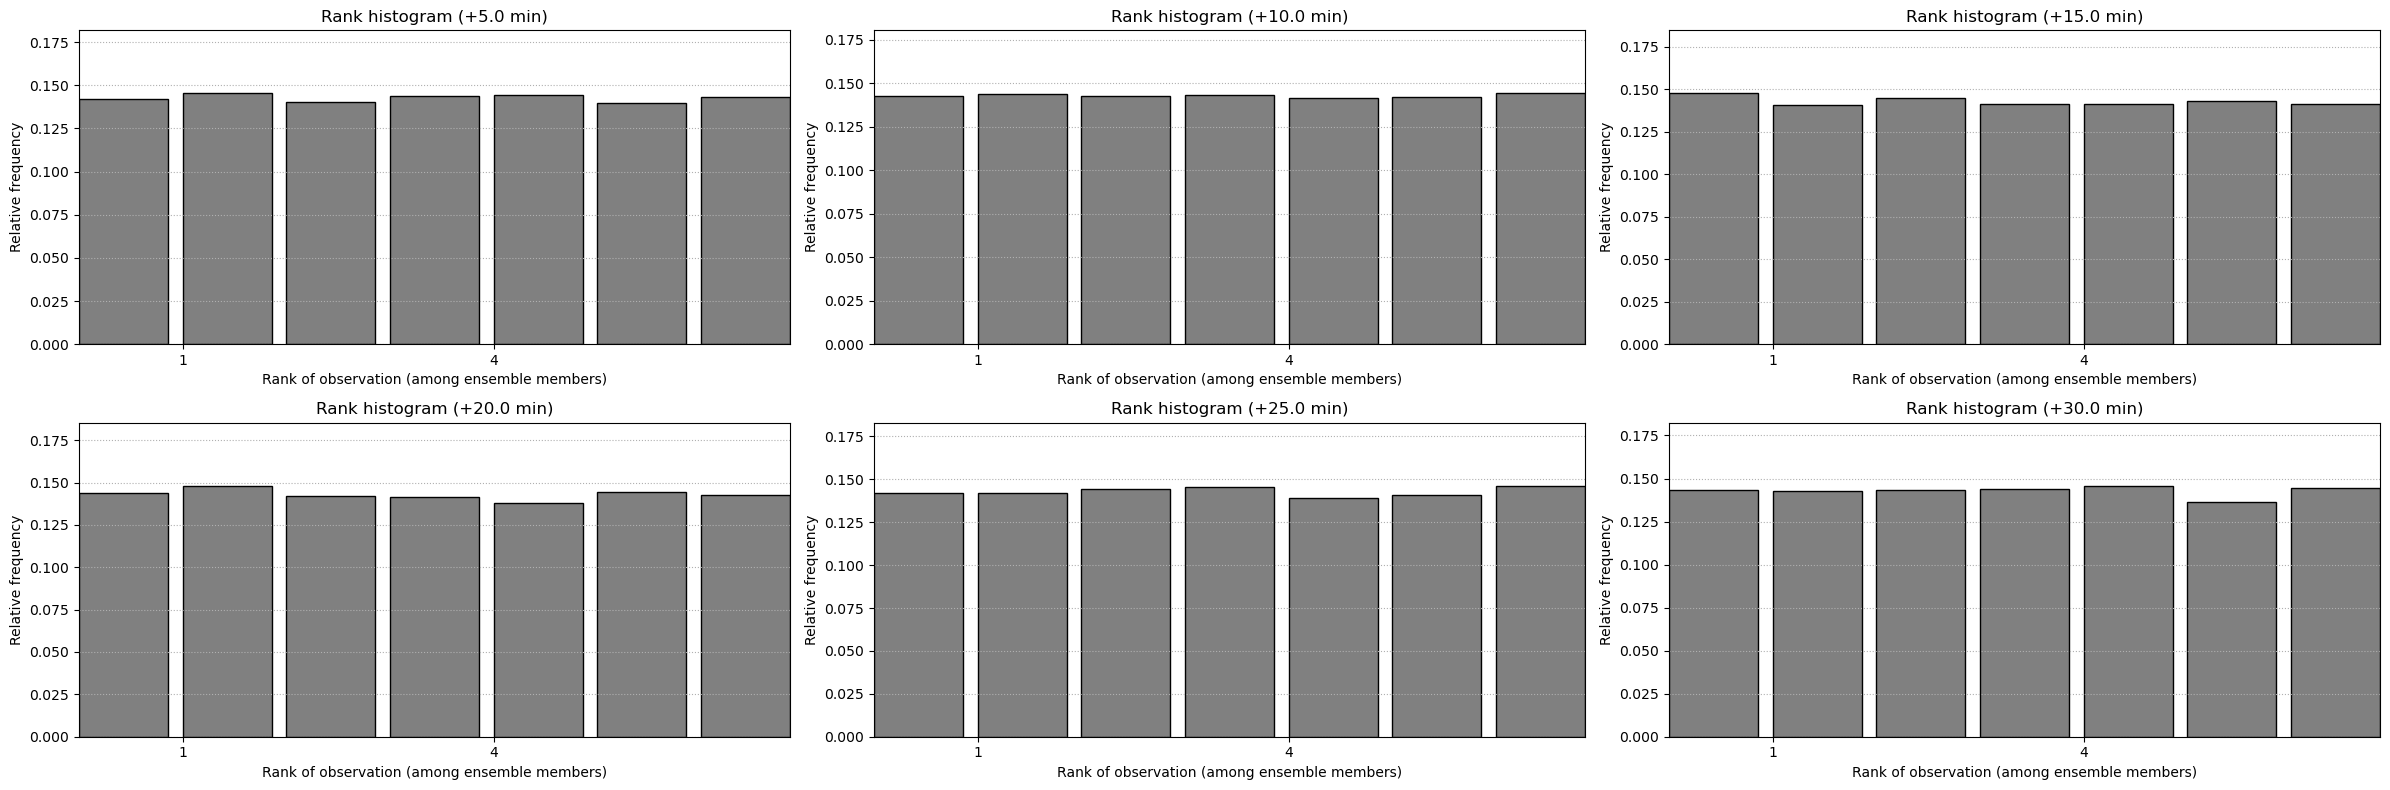

In [54]:
from pysteps import verification
import matplotlib.pyplot as plt
n_leadtimes = 6
timestep = 5.0
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(24, 8))
# Flatten the axes array 
axes = axes.ravel()
for i in range(n_leadtimes):
    ax = axes[i] 
    rankhist = verification.rankhist_init(n_leadtimes, 0)
    # verification.rankhist_accum(rankhist, R_f_steps[:, i, :, :], R_O_dbz[i, :, :])
    verification.rankhist_accum(rankhist, R_O_ens[:, i, :, :], R_O_dbz[i, :, :])
    verification.plot_rankhist(rankhist, ax)
    ax.set_title(f"Rank histogram (+{(i+1) * timestep} min)")
plt.tight_layout()
plt.show()

In [70]:
rankhist

{'num_ens_members': 6,
 'n': array([ 173,    0,    0,  953, 1642, 4732, 7047]),
 'X_min': 0}

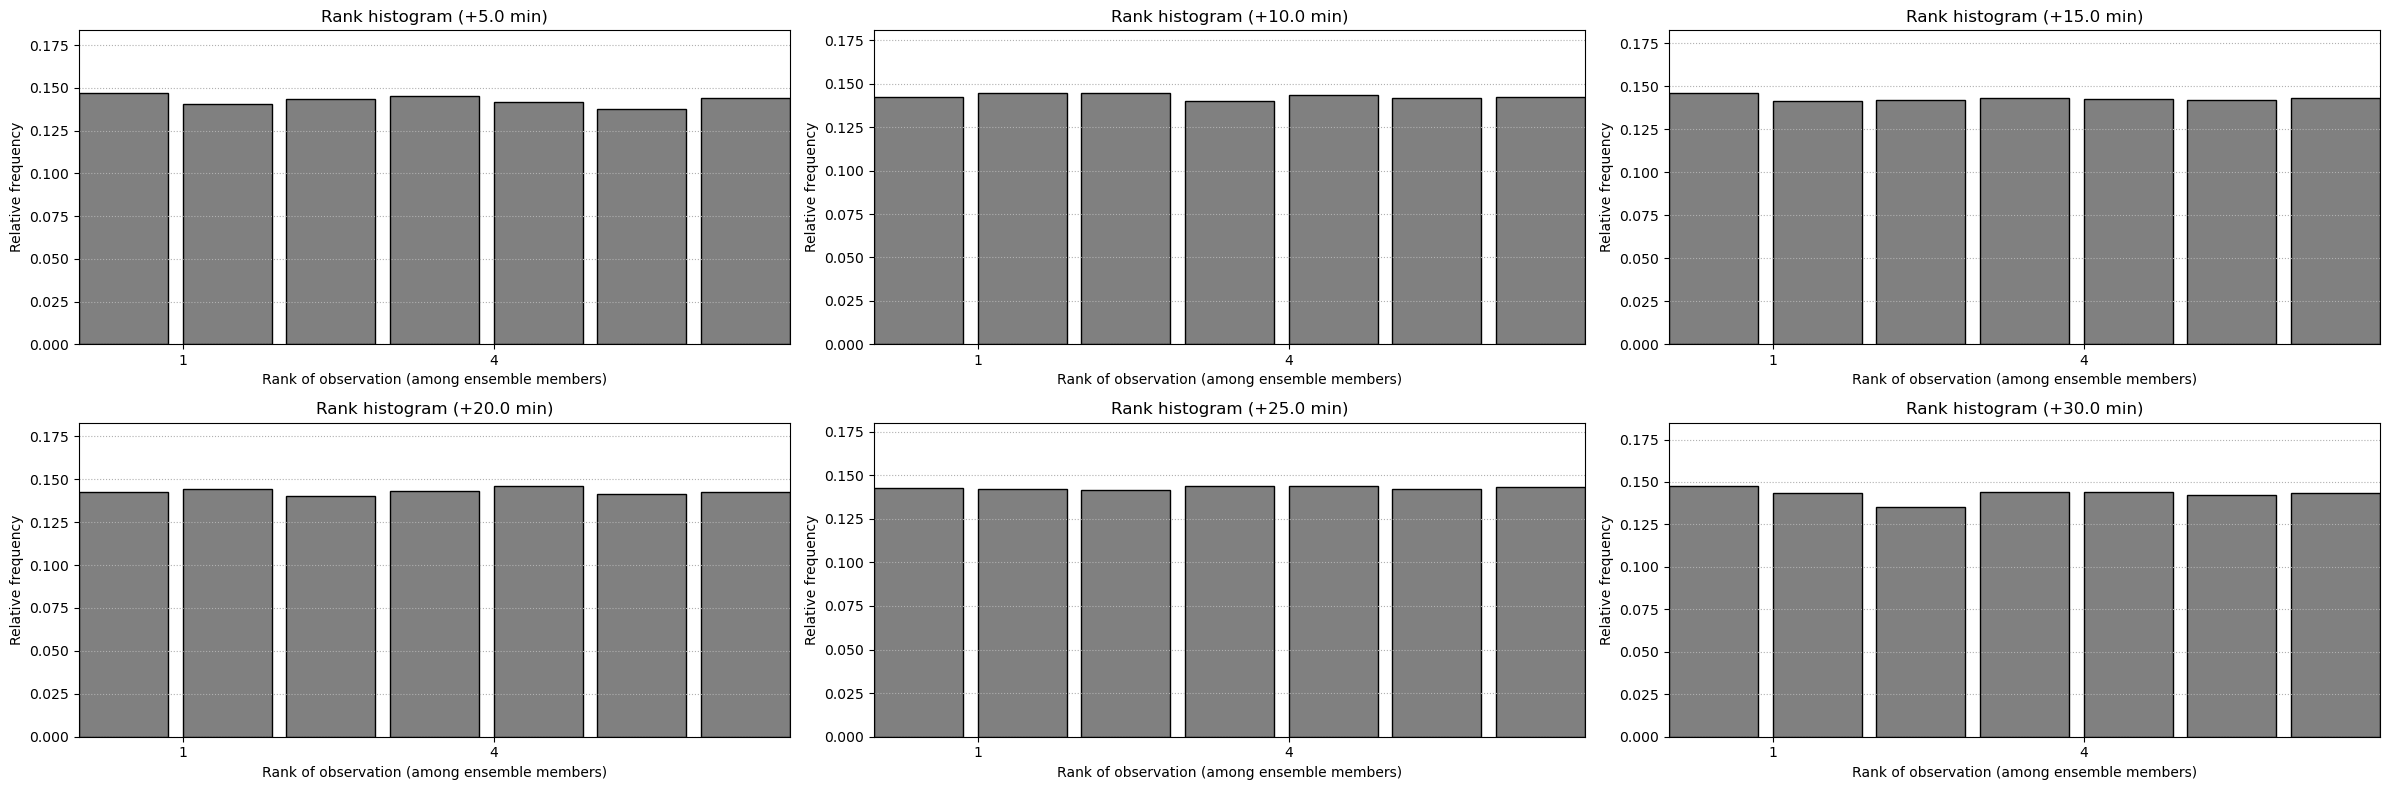

In [55]:
from pysteps import verification
import matplotlib.pyplot as plt
n_leadtimes = 6
timestep = 5.0
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(24, 8))
# Flatten the axes array 
axes = axes.ravel()
for i in range(n_leadtimes):
    ax = axes[i] 
    rankhist = verification.rankhist_init(n_leadtimes, 0)
    verification.rankhist_accum(rankhist, R_O_ens[:, i, :, :], R_O_dbz_nan[i, :, :])
    verification.plot_rankhist(rankhist, ax)
    ax.set_title(f"Rank histogram (+{(i+1) * timestep} min)")
plt.tight_layout()
plt.show()

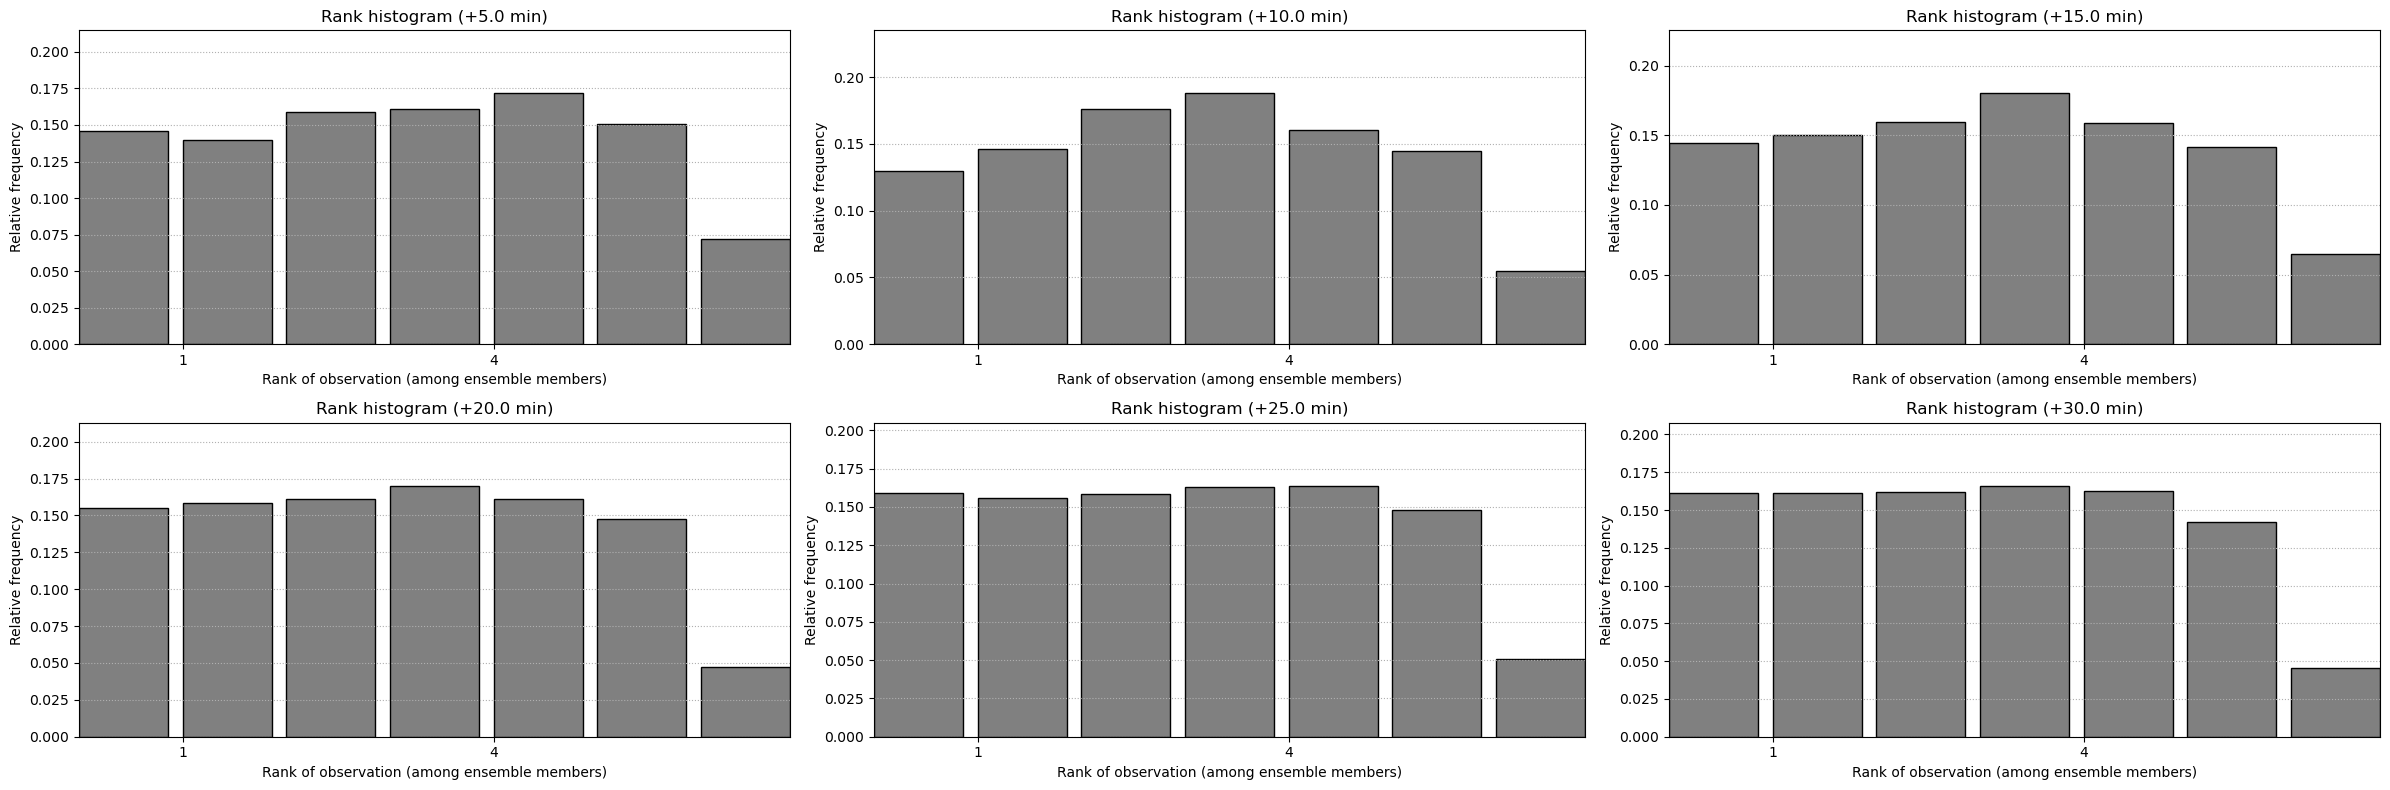

In [58]:
from pysteps import verification
import matplotlib.pyplot as plt
n_leadtimes = 6
timestep = 5.0
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(24, 8))
# Flatten the axes array 
axes = axes.ravel()
for i in range(n_leadtimes):
    ax = axes[i] 
    rankhist = verification.rankhist_init(n_leadtimes, 0)
    verification.rankhist_accum(rankhist, R_f_steps[:, i, :, :], R_O_dbz[i, :, :])
    verification.plot_rankhist(rankhist, ax)
    ax.set_title(f"Rank histogram (+{(i+1) * timestep} min)")
plt.tight_layout()
plt.show()

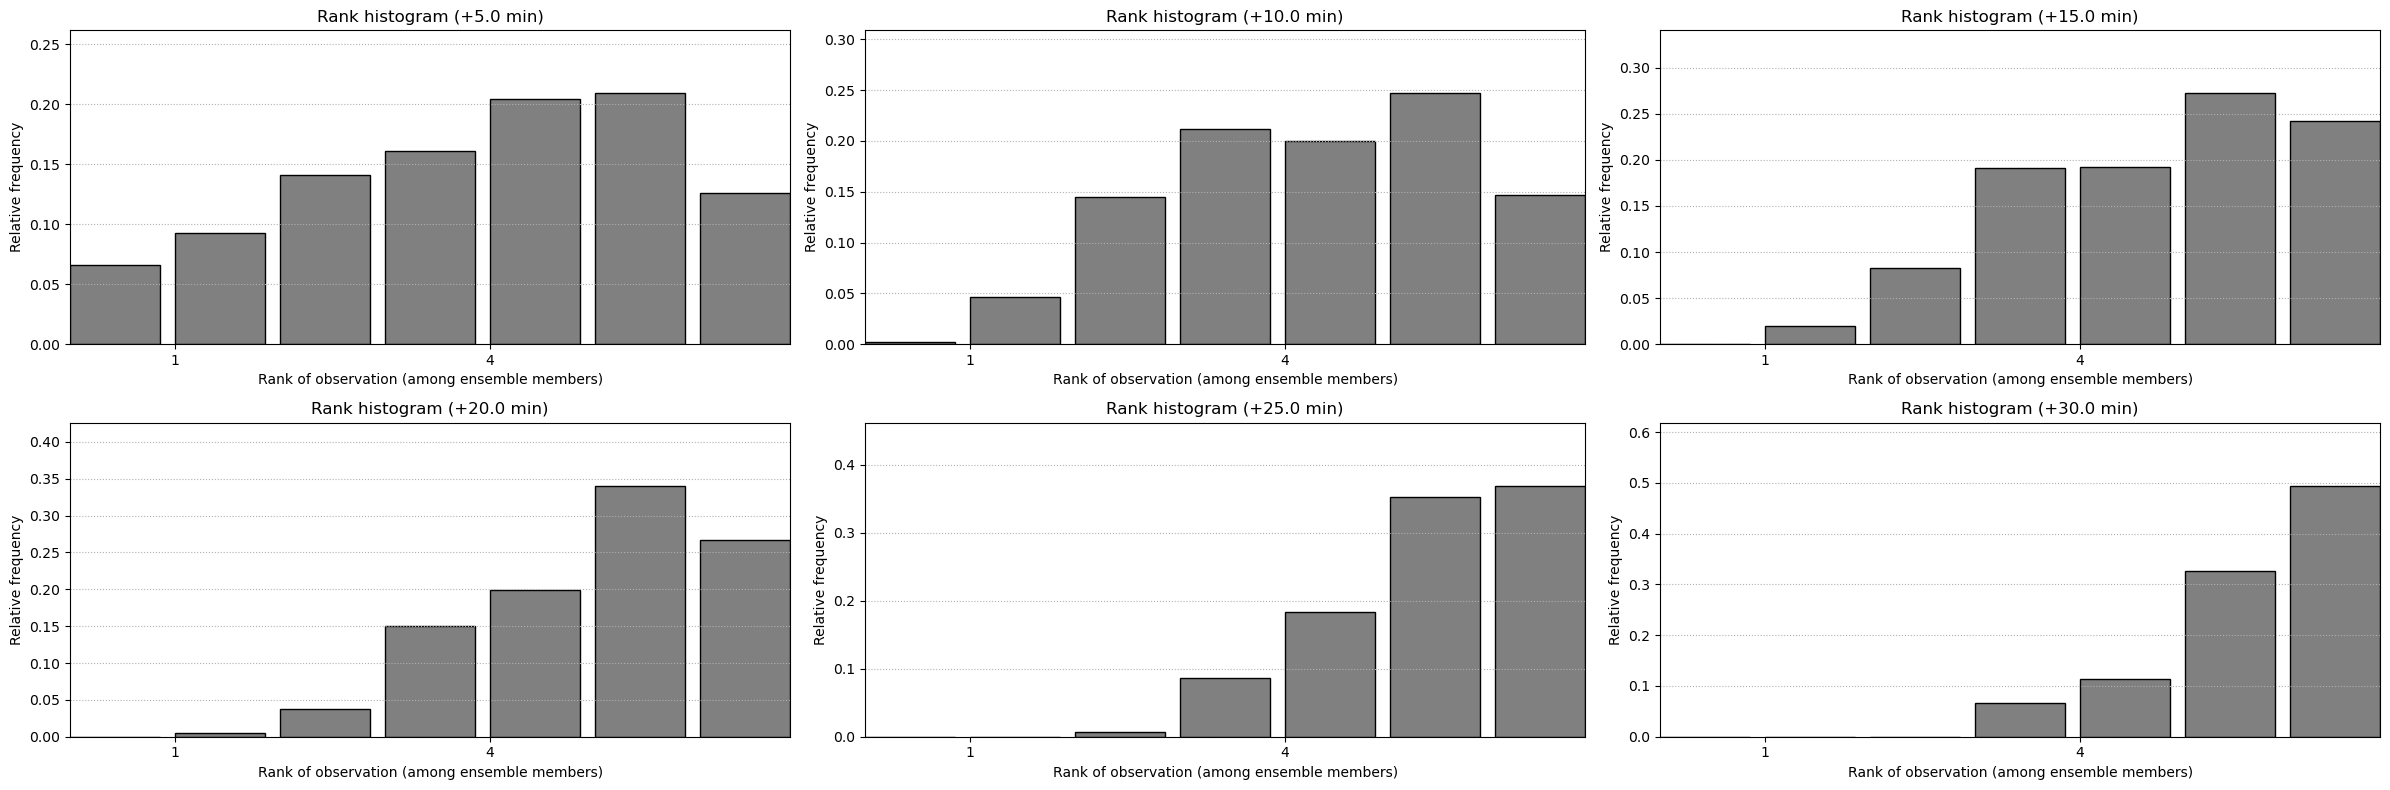

In [62]:
from pysteps import verification
import matplotlib.pyplot as plt
n_leadtimes = 6
timestep = 5.0
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(24, 8))
# Flatten the axes array 
axes = axes.ravel()
for i in range(n_leadtimes):
    ax = axes[i] 
    rankhist = verification.rankhist_init(n_leadtimes, 0)
    verification.rankhist_accum(rankhist, R_f_steps[:, i, :, :], R_O_dbz_nan[i, :, :])
    verification.plot_rankhist(rankhist, ax)
    ax.set_title(f"Rank histogram (+{(i+1) * timestep} min)")
plt.tight_layout()
plt.show()

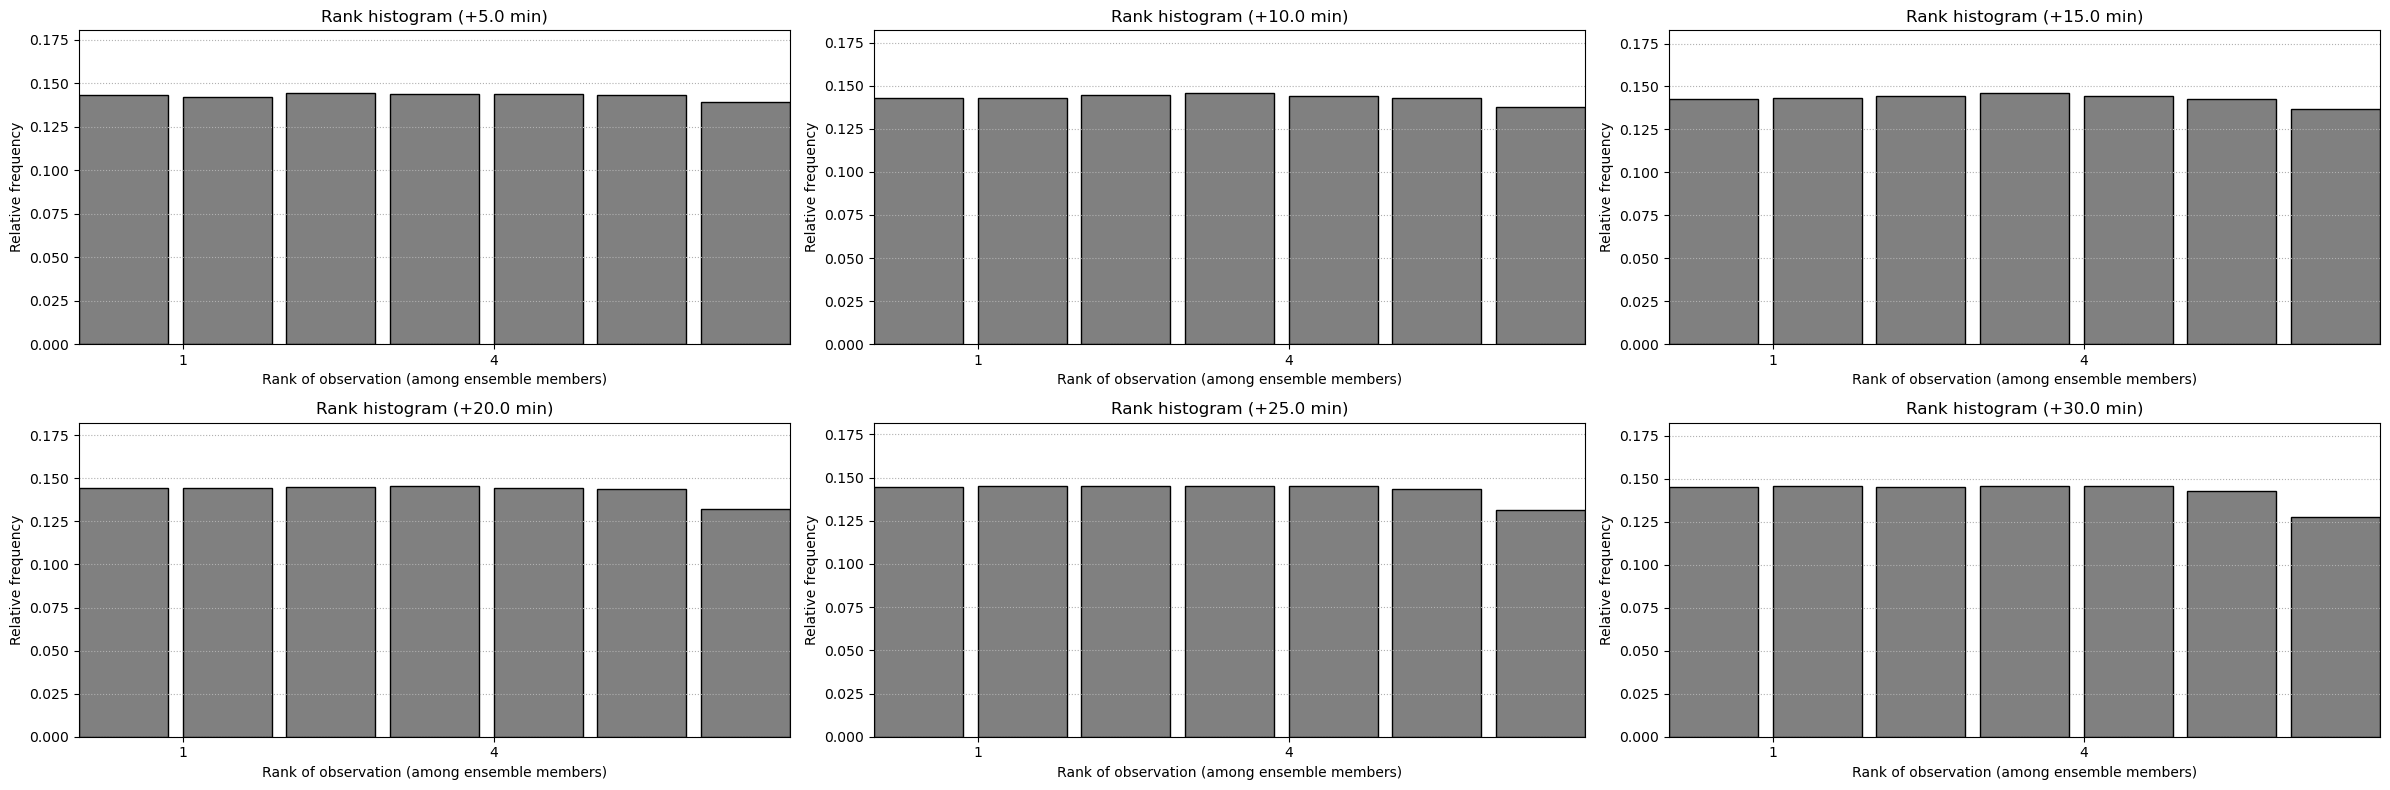

In [69]:
from pysteps import verification
import matplotlib.pyplot as plt
n_leadtimes = 6

timestep = 5.0
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(24, 8))
# Flatten the axes array 
axes = axes.ravel()
for i in range(n_leadtimes):
    ax = axes[i] 
    rankhist_1 = verification.rankhist_init(n_leadtimes, 0)
    verification.rankhist_accum(rankhist_1, R_f_steps_zeros[:, i, :, :], R_O_dbz_zeros[i, :, :])
    verification.plot_rankhist(rankhist_1, ax)
    ax.set_title(f"Rank histogram (+{(i+1) * timestep} min)")
plt.tight_layout()
plt.show()

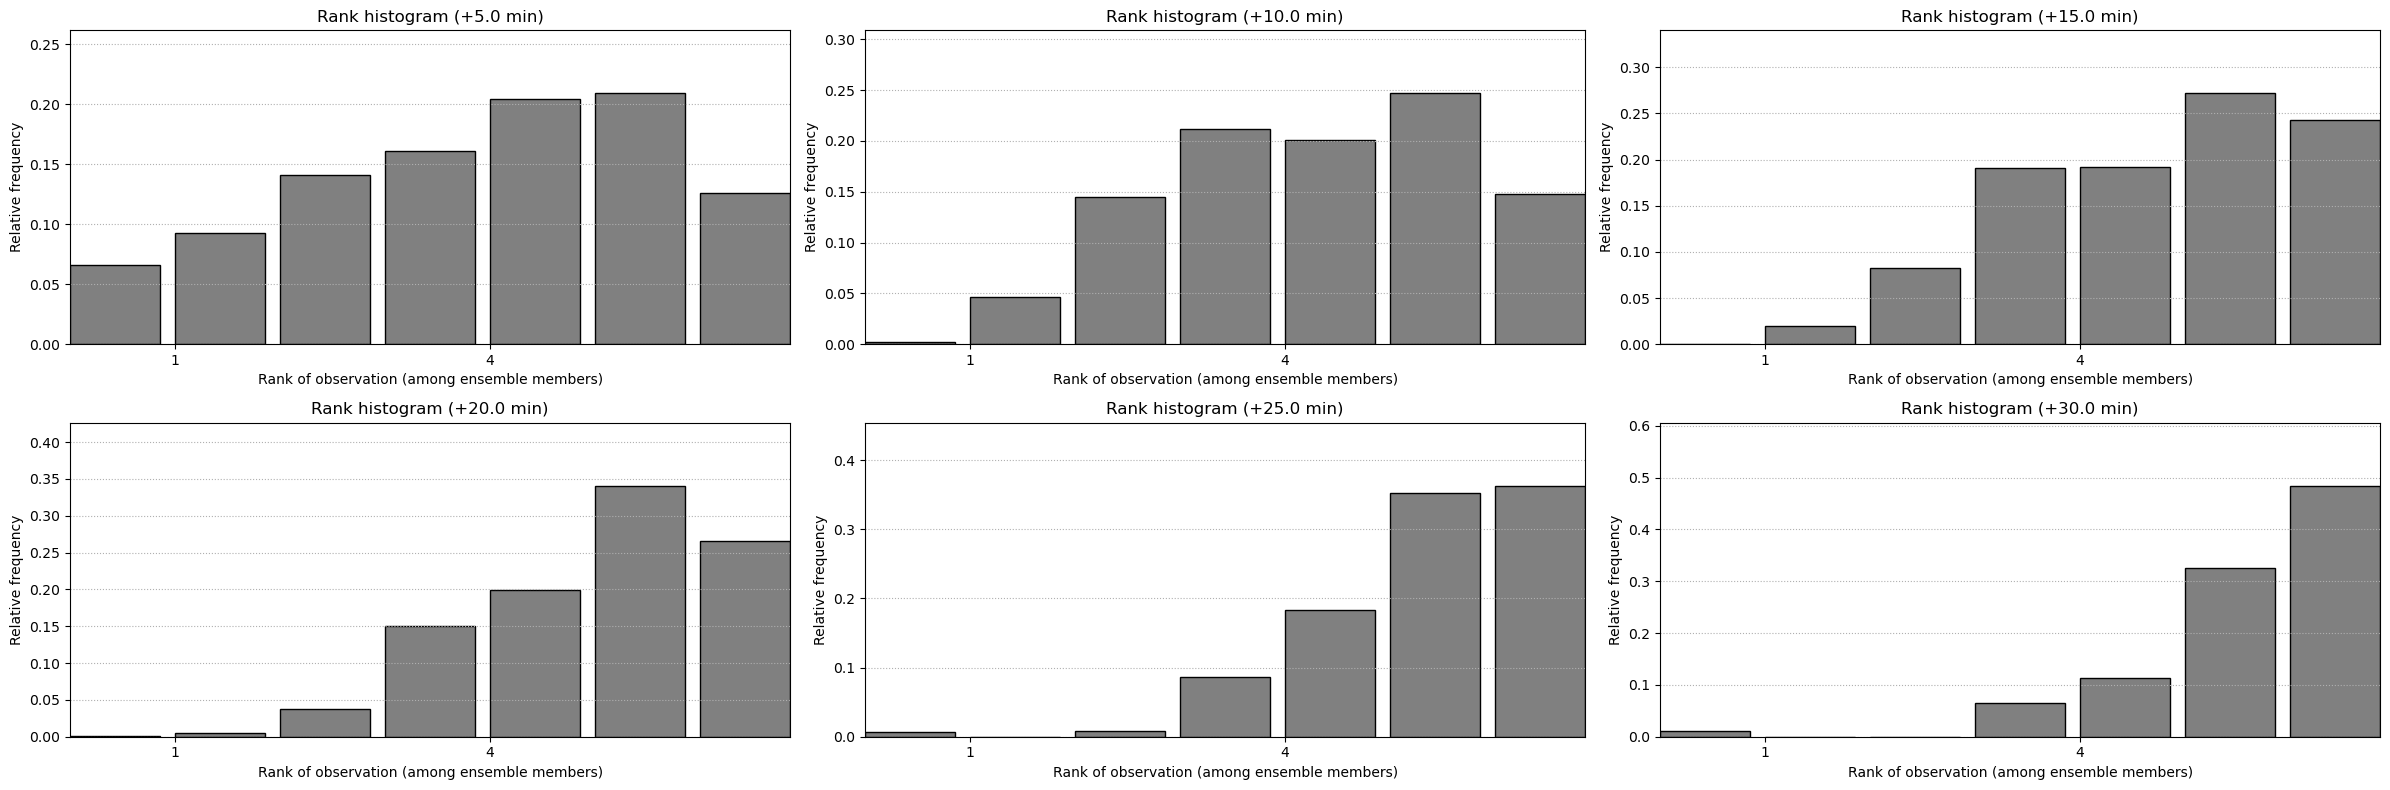

In [64]:
from pysteps import verification
import matplotlib.pyplot as plt
n_leadtimes = 6
timestep = 5.0
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(24, 8))
# Flatten the axes array 
axes = axes.ravel()
for i in range(n_leadtimes):
    ax = axes[i] 
    rankhist = verification.rankhist_init(n_leadtimes, 0)
    verification.rankhist_accum(rankhist, R_f_steps_thr[:, i, :, :], R_O_dbz_nan[i, :, :])
    verification.plot_rankhist(rankhist, ax)
    ax.set_title(f"Rank histogram (+{(i+1) * timestep} min)")
plt.tight_layout()
plt.show()

# Reliabiltiy Diagram

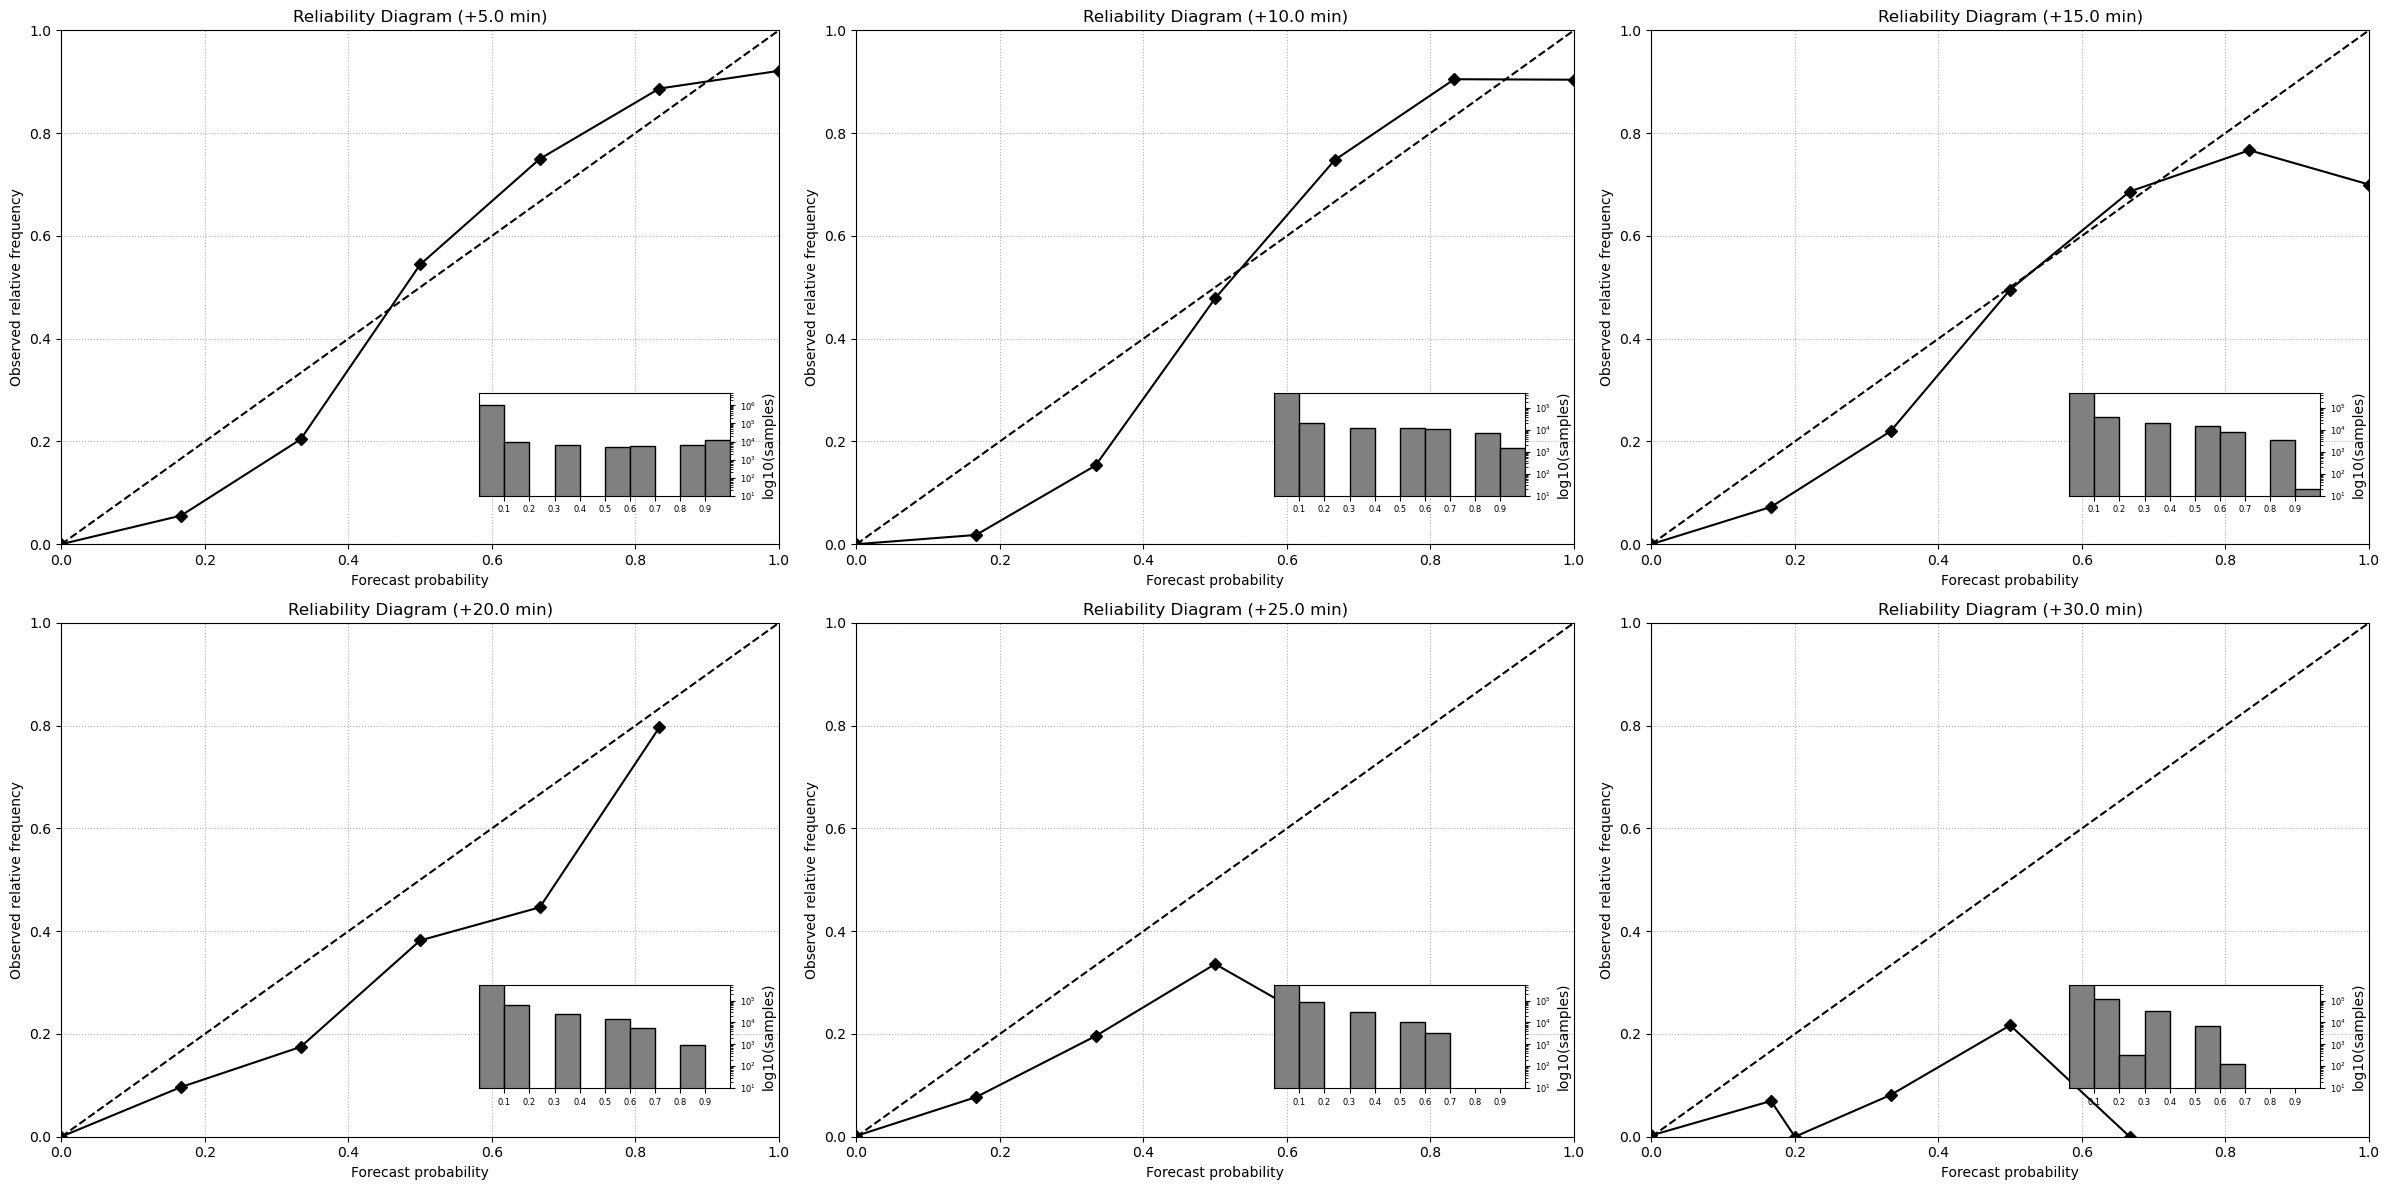

In [30]:
from pysteps import verification
import matplotlib.pyplot as plt
from pysteps.postprocessing import ensemblestats

n_leadtimes = 6
timestep = 5.0
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
axes = axes.ravel()  # Flatten the axes array for easy iteration

for i in range(n_leadtimes):
    ax = axes[i]  # Get the i-th Axes object
    # Initialize the reliability diagram
    reliability = verification.reldiag_init(0)
    # compute the exceedance probability of 0 dBZ from the ensemble
    P_f = ensemblestats.excprob(R_f_steps[:, i, :, :], 0, ignore_nan=True)
    # Accumulate the reliability data
    verification.reldiag_accum(reliability, P_f, R_O_dbz[i, :, :])
    # Plot the reliability diagram
    verification.plot_reldiag(reliability, ax)
    ax.set_title(f"Reliability Diagram (+{(i+1) * timestep} min)")
plt.tight_layout()
plt.show()

In [33]:
reliability

{'X_min': 0,
 'bin_edges': array([-1.000000e-06,  9.999920e-02,  1.999994e-01,  2.999996e-01,
         3.999998e-01,  5.000000e-01,  6.000002e-01,  7.000004e-01,
         8.000006e-01,  9.000008e-01,  1.000001e+00]),
 'n_bins': 10,
 'X_sum': array([    0.        , 19211.83333333,    62.4       , 11026.66666667,
            0.        ,  3551.        ,    88.        ,     0.        ,
            0.        ,     0.        ]),
 'Y_sum': array([2306, 8015,    0, 2686,    0, 1540,    0,    0,    0,    0]),
 'num_idx': array([892384, 115271,    312,  33080,      0,   7102,    132,      0,
             0,      0]),
 'sample_size': array([892384, 115271,    312,  33080,      0,   7102,    132,      0,
             0,      0]),
 'min_count': 10}

# ROC Curve

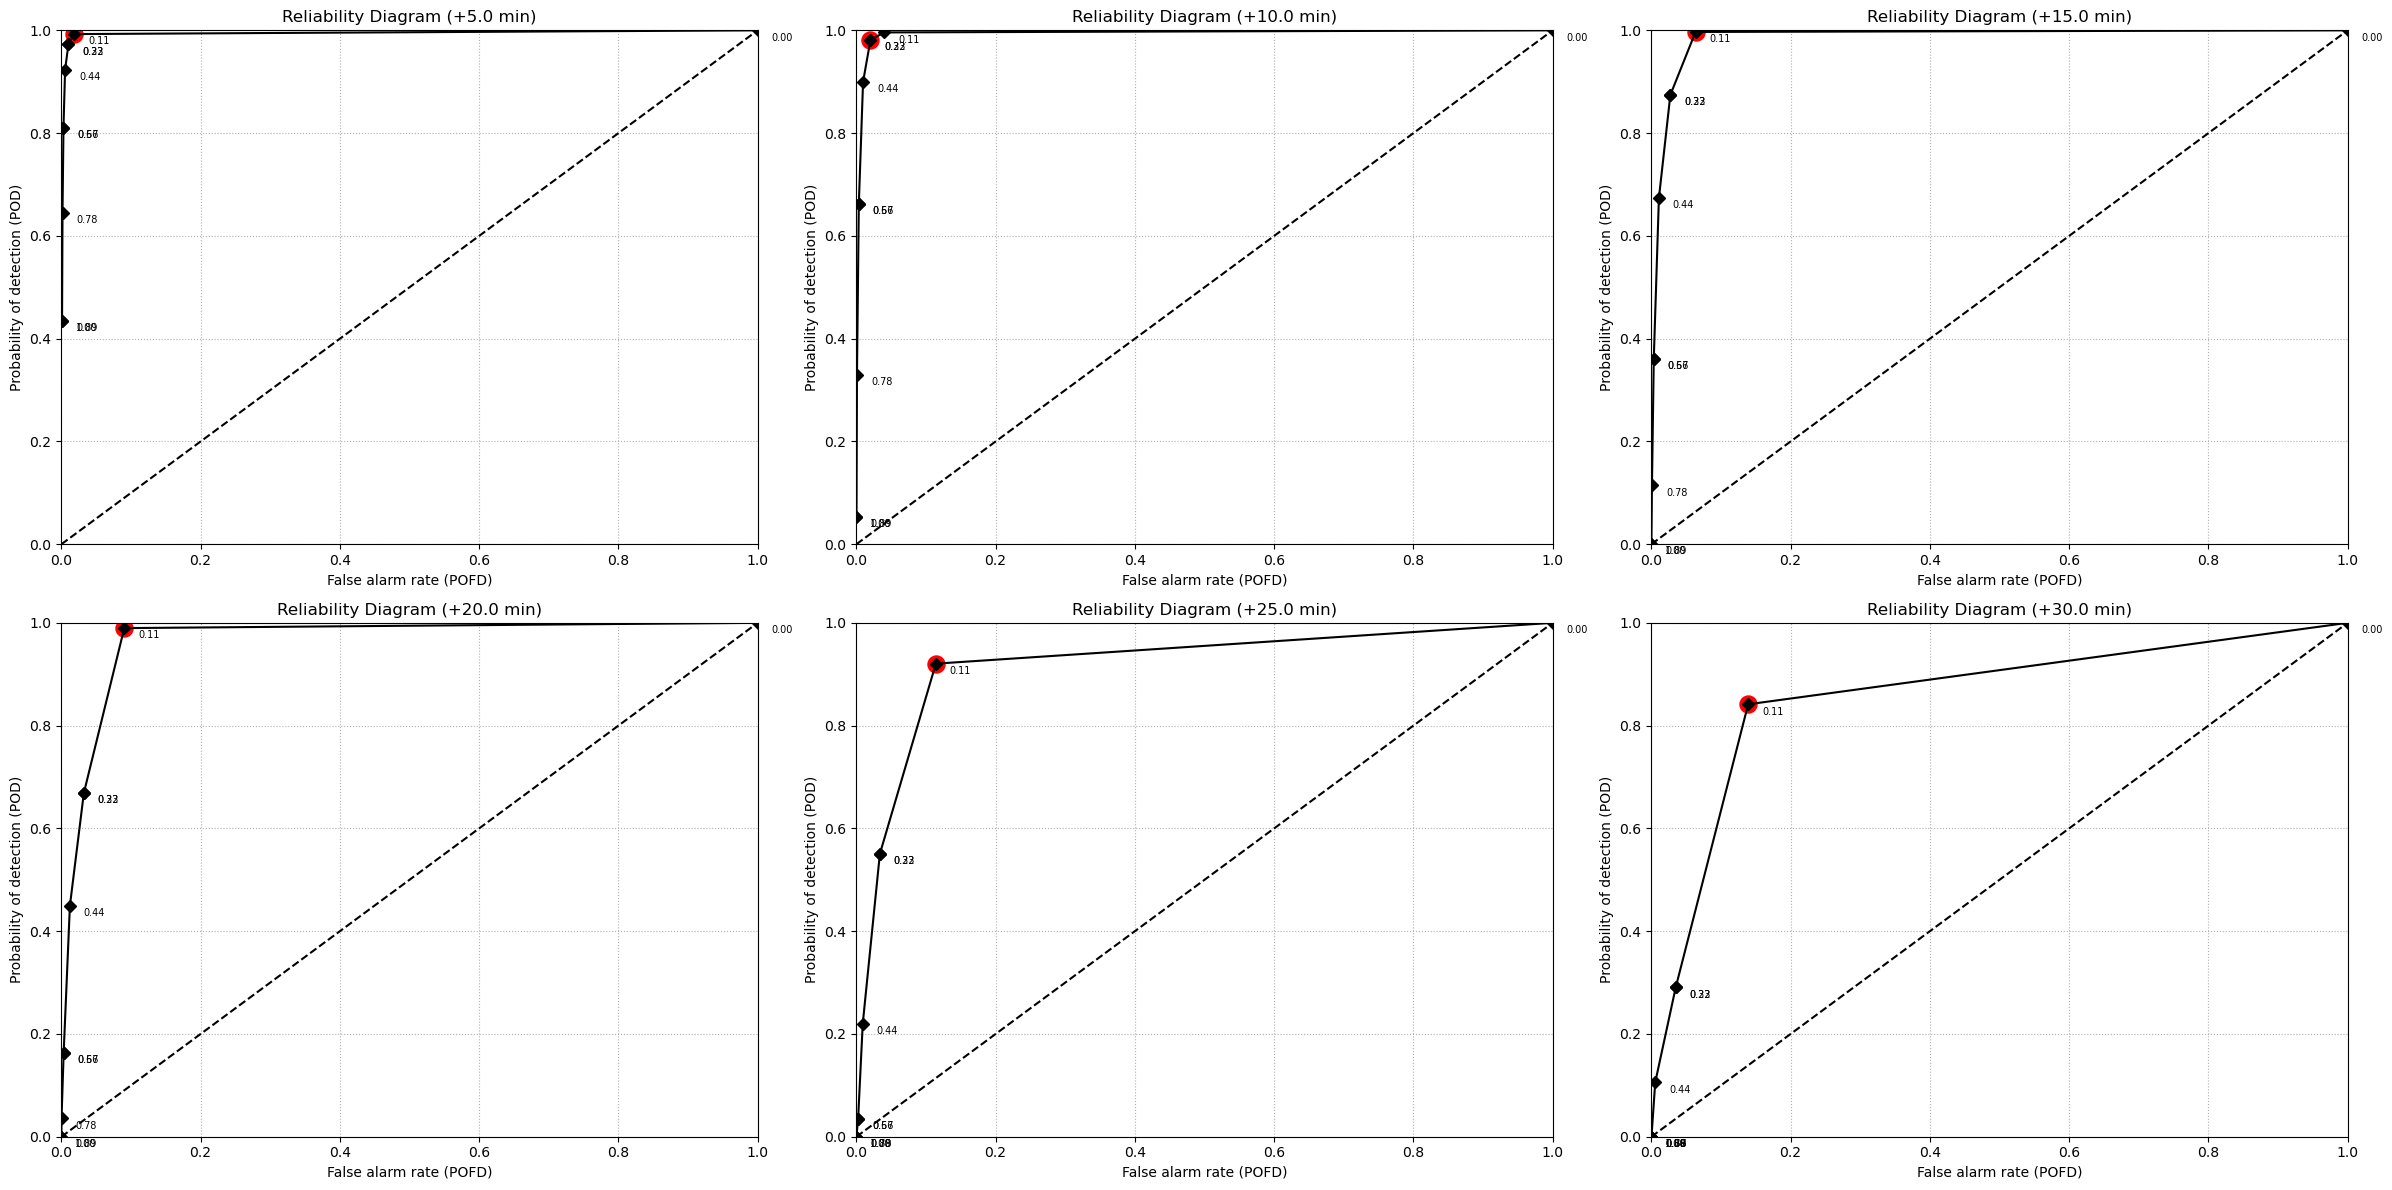

In [31]:
from pysteps import verification
import matplotlib.pyplot as plt
from pysteps.postprocessing import ensemblestats
n_leadtimes = 6
timestep = 5.0
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
axes = axes.ravel()  # Flatten the axes array for easy iteration
for i in range(n_leadtimes):
    ax = axes[i]  # Get the i-th Axes object
    # Initialize the reliability diagram
    roc= verification.ROC_curve_init(0, n_prob_thrs=10)
    # compute the exceedance probability of 0 dBZ from the ensemble
    P_f = ensemblestats.excprob(R_f_steps[:, i, :, :], 0, ignore_nan=True)
    # Accumulate the roc data
    verification.ROC_curve_accum(roc, P_f, R_O_dbz[i, :, :])
    # Plot the reliability diagram
    verification.plot_ROC(roc, ax, opt_prob_thr=True)
    ax.set_title(f"Reliability Diagram (+{(i+1) * timestep} min)")
plt.tight_layout()
plt.show()

In [34]:
roc

{'X_min': 0,
 'hits': array([14547, 12241,  4226,  4226,  1540,     0,     0,     0,     0,
            0]),
 'misses': array([    0,  2306, 10321, 10321, 13007, 14547, 14547, 14547, 14547,
        14547]),
 'false_alarms': array([1033734,  143656,   36088,   36088,    5694,     132,     132,
              0,       0,       0]),
 'corr_neg': array([      0,  890078,  997646,  997646, 1028040, 1033602, 1033602,
        1033734, 1033734, 1033734]),
 'prob_thrs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])}

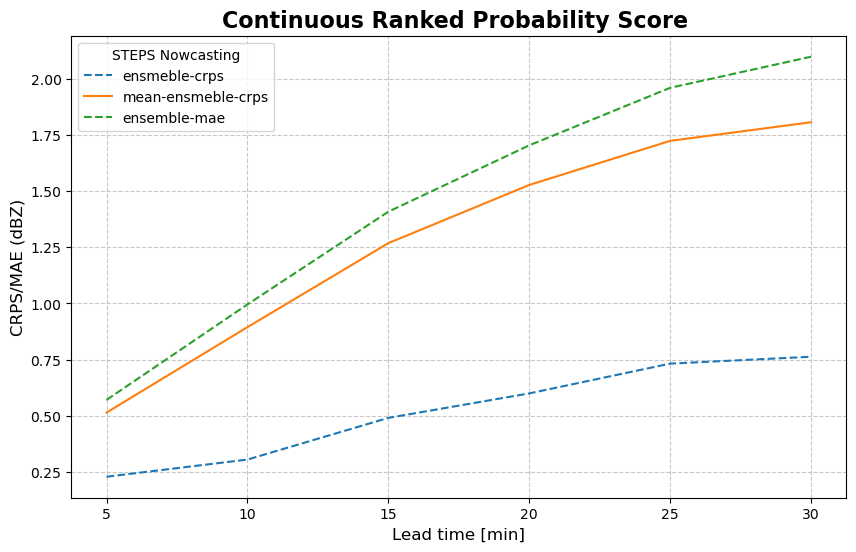

In [32]:
# Compute Pearson Correlation for all lead times
x = np.arange(1, n_leadtimes + 1) * timestep
crps =  verification.get_method("CRPS",type="probabilistic")
crps_score =[]

R_f_steps_mean_4D =np.reshape(R_f_steps_mean,(1,6,1024,1024)) 
crps_score_mean = []
for i in range(n_leadtimes):
    crps_score.append(crps(R_f_steps[:,i,:,:], R_O_dbz[i, :, :]))
    crps_score_mean.append(crps(R_f_steps_mean_4D[:,i,:,:], R_O_dbz[i, :, :]))
plt.figure(figsize=(10, 6))
plt.plot(x, crps_score,'--', label='ensmeble-crps')
plt.plot(x, crps_score_mean, label='mean-ensmeble-crps')
plt.plot(x, mae_score_ens,'--', label='ensemble-mae')
# plt.plot(x, mae_score,'--', label ="mean-mae")
plt.xlabel("Lead time [min]", fontsize=12)
plt.ylabel("CRPS/MAE (dBZ)", fontsize=12)
plt.title("Continuous Ranked Probability Score ", fontsize=16, weight="bold")
plt.legend(title="STEPS Nowcasting", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

In [35]:
crps_score

[np.float64(0.22833439093982055),
 np.float64(0.3047291897992749),
 np.float64(0.49046554880752113),
 np.float64(0.5994662102694859),
 np.float64(0.7321487455365511),
 np.float64(0.762801196082061)]